In [1]:
from ultralytics import YOLO
import numpy as np
import os
import polars as pl
from ultralytics import settings
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from ultralytics.utils.plotting import Annotator
import rembg

# Update a setting
settings.update({'mlflow': True})

extract = YOLO("runs/detect/train6/weights/best.pt")

In [2]:
def display_image(img_array, size=512):
    img = Image.fromarray(img_array)
    # img = img.resize((size, int(img.height // (img.width / size))))
    display(img)

def extract_cars(img, conf=0.128):
    results = extract(img, conf=conf)
    img_array = np.array(img)
    for result in results:
        for box in result.boxes:
            # Extract bounding box coordinates
            left, top, right, bottom = box.xyxy[0].int().tolist()
            yield rembg.remove(img_array[top:bottom, left:right])[:, :, [0, 1, 2,]]
            
SIZE = 64
cars = []
for image_path in os.listdir("test_images/"):
    image_path = os.path.join("test_images/", image_path)
    img = Image.open(image_path)
    img_np = np.array(img)  # Convert PIL image to NumPy array
    # display_image(img_np)
    for car in extract_cars(img, conf=0.5):
        cars.append(cv2.resize(car, dsize=(SIZE, SIZE)))


0: 448x640 (no detections), 89.0ms
Speed: 3.3ms preprocess, 89.0ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 car, 56.0ms
Speed: 3.2ms preprocess, 56.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 car, 99.2ms
Speed: 6.0ms preprocess, 99.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 car, 55.3ms
Speed: 2.3ms preprocess, 55.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 car, 56.8ms
Speed: 2.7ms preprocess, 56.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 car, 50.2ms
Speed: 2.3ms preprocess, 50.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 car, 51.8ms
Speed: 2.1ms preprocess, 51.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 car, 145.9ms
Speed: 14.2ms preprocess, 145.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0:

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.models import Model
import matplotlib.pyplot as plt

base_model = VGG19(include_top=False, weights='imagenet', input_shape=cars[0].shape)
for l in base_model.layers:
    l.trainable = False
features_model = Model(inputs=base_model.input, outputs=base_model.layers[1].output)
features_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
Total params: 1792 (7.00 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1792 (7.00 KB)
_________________________________________________________________


In [5]:
def extract_features(car):
    car = np.expand_dims(car, axis=0)
    car = preprocess_input(car)
    features = features_model.predict(car)
    return features.flatten()

In [6]:
from sklearn.decomposition import PCA

all_features = np.vstack([extract_features(car) for car in cars])
pca = PCA(n_components=2)  # Adjust number of components as needed
pca_features = pca.fit_transform(all_features)

1/1 [==============================] - 0s 16ms/step


0 -119.32227 -107.60127


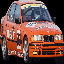

1 -6.2994742 57.835484


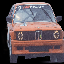

2 -45.058636 -114.40319


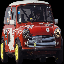

3 -121.25163 -114.57327


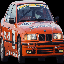

4 -68.70414 178.07988


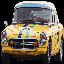

5 176.26141 -9.591856


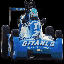

6 103.66493 -19.65665


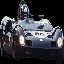

7 -67.51182 -60.610245


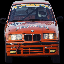

8 113.699875 1.8004768


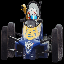

9 15.586912 -7.249391


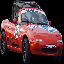

10 -13.344583 -77.92662


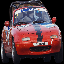

11 30.280579 136.08707


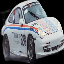

12 -52.62664 -65.74829


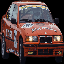

13 184.42816 -6.1763225


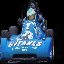

14 -129.80269 209.7342


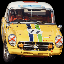

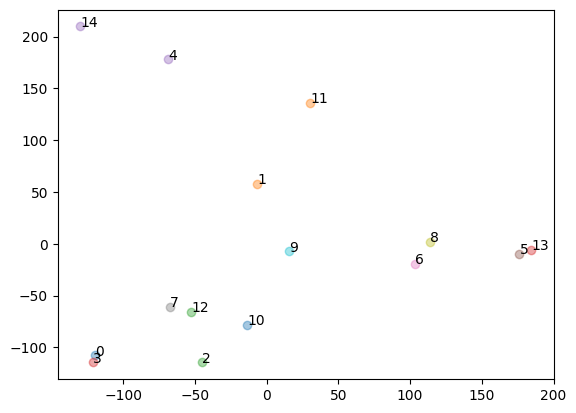

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pca_features_normalised = scaler.fit_transform(pca_features) * 100
for i, (x, y) in enumerate(pca_features_normalised[:, [0, 1]]):
    print(i, x, y)
    display_image(cars[i])
    plt.text(x, y, str(i))
    plt.scatter(x, y, data=cars[i], alpha=0.4)

In [ ]:
car = np.expand_dims(cars[0], axis=0)
car = preprocess_input(car)
features = features_model.predict(car)

square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(features[0, :, :, ix-1], cmap='gray')
        ix += 1
        # show the figure
plt.show()